In [1]:
import os

In [2]:
from langgraph.graph import MessagesState,StateGraph, END, START
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.prebuilt import tools_condition # this is the checker for the if you got a tool back
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from typing import Annotated, TypedDict
import operator
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition # this is the checker for the
from langgraph.prebuilt import ToolNode

In [3]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [4]:
def multiply(a: int, b: int) -> int:
    """
    Multiply a and b.
    Args:
        a: first int
        b: second int
    """
    return a * b

In [5]:
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

In [6]:
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [8]:
search = DuckDuckGoSearchRun()

In [9]:
search.invoke("who is a current president of USA?")

"The White House, official residence of the president of the United States, in 2008 The president of the United States is the head of state and head of government of the United States, [1] indirectly elected to a four-year term via the Electoral College. [2] Under the U.S. Constitution, the officeholder leads the executive branch of the federal government and is the commander-in-chief of the ... Here is a list of the presidents and vice presidents of the United States along with their parties and dates in office. Donald Trump has officially become the 47th president of the United States. In a special ceremony called an inauguration, President Trump took over from Joe Biden as America's new leader. Donald Trump, who overcame impeachments, criminal indictments and a pair of assassination attempts to win another term in the White House, was sworn in Monday as the 47th U.S. president taking ... Donald Trump was sworn in Monday as the 47th president of the United States in one of the most r

In [10]:
tools = [add, multiply, divide, search]

In [11]:
llm_with_tools=llm.bind_tools(tools)

In [12]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")

In [13]:
def reasoner(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [14]:
# Graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("reasoner", reasoner)

builder.add_node("tools", ToolNode(tools)) # for the tools

# Add edges
builder.add_edge(START, "reasoner")

builder.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)

builder.add_edge("tools", "reasoner")
react_graph = builder.compile()

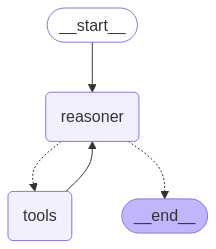

In [15]:
# Display the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [20]:
messages = [HumanMessage(content="What is 2 times of narendramodi's age?")]

In [21]:
messages = react_graph.invoke({"messages": messages})

In [22]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 times of narendramodi's age?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_pz09)
 Call ID: call_pz09
  Args:
    query: narendra modi age
================================= Tool Message =================================
Name: duckduckgo_search

Narendra Modi is the 14th prime minister of India. His Hindu nationalist policies and some of his economic reforms have proved controversial to many within and outside India. Learn about the life and achievements of Narendra Modi, the current Prime Minister of India, who was born on September 17, 1950, in Gujarat. Find out his full name, education, political journey, and role in the BJP and RSS. List of all Prime Ministers of India till 2025: Narendra Modi is the current and 14th Prime Minister of India who assumed office on 10 June 2024. Jawaharlal Nehru is the first and the longest 

In [32]:
messages = [HumanMessage(content="What is the result when you add 100 years to the current age of Elon Musk?")]

In [33]:
messages = react_graph.invoke({"messages": messages})

In [34]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the result when you add 100 years to the current age of Elon Musk?
================================== Ai Message ==================================
Tool Calls:
  add (call_jzc9)
 Call ID: call_jzc9
  Args:
    a: 51
    b: 100
================================= Tool Message =================================
Name: add

151
================================== Ai Message ==================================

151


In [36]:
import yfinance as yf

def get_stock_price(ticker: str) -> float:
    """Gets a stock price from Yahoo Finance.

    Args:
        ticker: ticker str
    """
    # """This is a tool for getting the price of a stock when passed a ticker symbol"""
    stock = yf.Ticker(ticker)
    return stock.info['previousClose']

In [37]:
get_stock_price("AAPL")

188.38

In [38]:
# Node
def reasoner(state):
    query = state["query"]
    messages = state["messages"]
    # System message
    sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.")
    message = HumanMessage(content=query)
    messages.append(message)
    result = [llm_with_tools.invoke([sys_msg] + messages)]
    return {"messages":result}

In [39]:
tools = [add, multiply, divide, search, get_stock_price]

In [40]:
llm_with_tools = llm.bind_tools(tools)

In [41]:
class GraphState(TypedDict):
    """State of the graph."""
    query: str
    finance: str
    final_answer: str
    # intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    messages: Annotated[list[AnyMessage], operator.add]

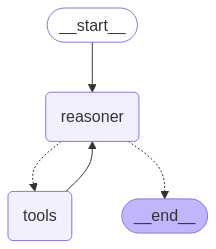

In [42]:
# Graph
workflow = StateGraph(GraphState)

# Add Nodes
workflow.add_node("reasoner", reasoner)
workflow.add_node("tools", ToolNode(tools)) # for the tools

# Add Edges
workflow.add_edge(START, "reasoner")

workflow.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
workflow.add_edge("tools", "reasoner")
react_graph = workflow.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [46]:
response = react_graph.invoke({"query": "What is the stock price of Apple and add 1000 to it", "messages": []})

In [47]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the stock price of Apple and add 1000 to it
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_h7gv)
 Call ID: call_h7gv
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

188.38
================================ Human Message =================================

What is the stock price of Apple and add 1000 to it
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_c70a)
 Call ID: call_c70a
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

188.38
================================ Human Message =================================

What is the stock price of Apple and add 1000 to it
================================== Ai Me